In [ ]:
#install latest library
import os

os.chdir('./drive/MyDrive/Medical_Image_Analysis')
!pip install -r requirements.txt

In [ ]:
#import library
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import sys
import cv2 as cv

from pathlib import Path
from utils import my_dataset
from utils.img_utils import to_npimg
from network import SegNet, SegNet_cons, AttNet, PseudoEdgeNet
from losses import BCE_loss, IoU_eval, L1_loss, Dice_eval
from torch.nn import functional as F
from torch.optim import lr_scheduler

0.4.0


# Global variable

In [ ]:
data_import_options = {
    'stage': 0,
    'cp_time': 'best',
    'data_name': 'MoNuSeg',
    'k_fold': 3,
    'random_shift': 0, 
    'model_name': 'Seg_Att_Full',
    'mode_data_load': 'read',
    'mode_label': 'Sp',
    'cut_size': None,
    'bs': 2,
    'seed': 12,
    'aug_its': 4,
    'preprocess': 'unit',
    'kernel': None,
    'device': 'cuda',
    'pp_on_origin': None,
    'w_origin': False
} 

train_options = {
    'epochs': 60,
    'my_w1_1': 1,      #weight in att loss, point labels
    'my_w1_2': 0.4,    #weight in att loss, voronoi labels
    'my_w2': 0.8,       #weight on seg loss
    'my_w3': 1,     #weight on att loss
    'my_w4': 0.4,     #weight on cons loss
    'my_lr': 0.001,
    'weight_decay': 0.0005,
    'my_patience': 4,
    'mode_stage2': 'retrain',
    'cons_net_n': 4,
    'framework': 'Seg_Att',  #Seg, Seg_Cl, Seg_Att, Seg_Att_Cl, SAC, Full, PseudoEdgeNet
    'is_1000' : False
}

if data_import_options['data_name'] == 'MoNuSeg' and data_import_options['cut_size'] == None:
    train_options['is_1000'] = True
if data_import_options['stage'] > 0 and train_options['framework'] != 'SAC':
    train_options['framework'] =  train_options['framework'] + '_Cl'
if data_import_options['stage'] > 0:
    data_import_options['mode_data_load'] = 'gen'
if data_import_options['random_shift'] > 0:
    data_import_options['model_name'] = data_import_options['model_name'] + \
                             '_r' + str(data_import_options['random_shift'])

cp_PATH = './checkpoints/'+ data_import_options['data_name'] \
                          +'/stage' + str(data_import_options['stage']) \
                          + '/' + data_import_options['model_name'] 
Path(cp_PATH).mkdir(parents=True, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, data_import_options['k_fold'])

cuda 3


# Import data

In [ ]:
train_dl, val_dl, test_dl, test_ds, len_train, len_val, _, _ =\
    my_dataset.get_data(**data_import_options)

print(len_train, len_val)

Loading dataset...


100%|██████████| 30/30 [00:01<00:00, 18.18it/s]


Done!
(30, 1000, 1000, 3) (30, 1000, 1000, 3)
Augmenting data...


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Done!
96 3


# show data

In [ ]:
'''
w, h = 200, 200
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
this_data_ids = os.listdir('./datasets/TNBC/Input_Images')
this_i = 0

axs = axs.flatten()

axs[0].imshow(cv.cvtColor(cv.imread('./datasets/TNBC/Input_Images/' + \
                                    this_data_ids[this_i]), cv.COLOR_BGR2RGB))
axs[1].imshow(cv.imread('./datasets/TNBC/Labels_Sp/stage0/'+this_data_ids[this_i], cv.IMREAD_UNCHANGED))
axs[2].imshow(cv.cvtColor(cv.imread('./datasets/TNBC/method1/Input_Images/' + \
                                    this_data_ids[this_i][:-4]+'_norm.png'), cv.COLOR_BGR2RGB))
axs[3].imshow(cv.imread('./datasets/TNBC/method1/Labels_Sp/stage0/'+ \
                                this_data_ids[this_i], cv.IMREAD_UNCHANGED))

plt.show()
'''

"\nw, h = 200, 200\nfig, axs = plt.subplots(2, 2, figsize=(8, 8))\nthis_data_ids = os.listdir('./datasets/TNBC/Input_Images')\nthis_i = 0\n\naxs = axs.flatten()\n\naxs[0].imshow(cv.cvtColor(cv.imread('./datasets/TNBC/Input_Images/' +                                     this_data_ids[this_i]), cv.COLOR_BGR2RGB))\naxs[1].imshow(cv.imread('./datasets/TNBC/Labels_Sp/stage0/'+this_data_ids[this_i], cv.IMREAD_UNCHANGED))\naxs[2].imshow(cv.cvtColor(cv.imread('./datasets/TNBC/method1/Input_Images/' +                                     this_data_ids[this_i][:-4]+'_norm.png'), cv.COLOR_BGR2RGB))\naxs[3].imshow(cv.imread('./datasets/TNBC/method1/Labels_Sp/stage0/'+                                 this_data_ids[this_i], cv.IMREAD_UNCHANGED))\n\nplt.show()\n"

# define training process 

In [ ]:
criterion1 = BCE_loss.full()
criterion2 = L1_loss.partial(w1=train_options['my_w1_1'], w2=train_options['my_w1_2'])
criterion3 = L1_loss.cons_loss()


if train_options['framework'] == 'PseudoEdgeNet':
    criterion1 = BCE_loss.partial()

IoU = IoU_eval.sigmoid()
Dice = Dice_eval.dice()

criterions = [criterion1, criterion2, criterion3, Dice, IoU]
network_path = './checkpoints/'+str(data_import_options['data_name']) + '/stage' \
                                 + str(data_import_options['stage']-1) \
                                 + '/' + str(data_import_options['model_name']) \
                                 + '/' + str(data_import_options['k_fold']) \
                                 + '.pt' if data_import_options['cp_time'] == 'best' else \
                                './checkpoints/'+str(data_import_options['data_name'])  \
                                 + '/stage' + str(data_import_options['stage']-1) \
                                 + '/' + str(data_import_options['model_name']) \
                                 + '/' +  str(data_import_options['k_fold']) + '_f.pt' 
model_set = []

if data_import_options['stage'] > 0 and train_options['mode_stage2'] == 'refine':
    total_net = torch.load(network_path, map_location=device)
    mySegNet = total_net[0]
    myAttNet = total_net[1]
    train_options['my_lr'] = train_options['my_lr']/2
    train_options['epochs'] = 40
else:
    if train_options['framework'] == 'SAC' or train_options['framework'] == 'Full':
        mySegNet = SegNet_cons.build_network(device, 32, train_options['cons_net_n'], train_options['is_1000'])
        myAttNet = AttNet.build_network(device, 32, train_options['is_1000'])
        model_set.append(mySegNet)
        model_set.append(myAttNet)
    elif train_options['framework'] == 'PseudoEdgeNet':
        mySegNet = PseudoEdgeNet.build_network(device, train_options['is_1000'])        
        model_set.append(mySegNet)
    elif train_options['framework'] == 'Seg_Att' or train_options['framework'] == 'Seg_Att_Cl':
        mySegNet = SegNet.build_network(device, 32, train_options['is_1000'])
        myAttNet = AttNet.build_network(device, 32, train_options['is_1000']) 
        model_set.append(mySegNet)
        model_set.append(myAttNet)
    else:
        mySegNet = SegNet.build_network(device, 32, train_options['is_1000'])
        model_set.append(mySegNet)

paras_set = []
for e in model_set:
    paras_set += list(e.parameters())

optimizer = torch.optim.Adam(paras_set,
                            lr=train_options['my_lr'], 
                            weight_decay=train_options['weight_decay'])


loss_record_train = []
loss_record_val = []
loss_record_test = []

loss_dic = {
    'seg_loss  ': 0, 
    'att_loss  ': 0,
    'cons_loss ': 0,
    'Dice      ': 0,
    'IoU       ': 0,
    'total_loss': 0
}

#learning rate schedule                    
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, \
                                           train_options['my_patience'],\
                                           verbose=True)

#model checkpoint
def model_cp(model, PATH, epoch, model_name, moniter_name, best_moniter):
    #model_name =  model_name+'.' + str(cv_i) + str(best_moniter) + '.pt'
    #model_name = str(cv_i) + '_' + str(epoch) + '.pt'
    model_name =  str(data_import_options['k_fold']) + '.pt'
    PATH = os.path.join(PATH, model_name)
    torch.save(model, PATH)
    
    print()
    print(f'Save best model, {moniter_name}: {best_moniter}')

def up_dict_batch(total, batch, nums):
    for key in total:
        total[key] += batch[key]*nums
    
    return total

def up_dict_epoch(dic, lens):
    for key in dic:
        dic[key] /= lens

    return dic

def show_dict(dics):
    if len(dics) > 1:
        for key in dics[0]:
            print(f'{key}:', end='')
            for dic in dics:
                print(f'{dic[key]:>8.4f}', end='')
            print()
    else:
        for key in dics[0]:
            print(f'{key}:{dics[0][key]:>8.4f}')

def loss_batch_Seg(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg = model_set[0](xb)

    eval_re.append(criterions[0](y_seg, yb[:,[2]]))
        
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))

    total_loss = eval_re[0] 

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        if key == 'seg_loss  ': 
            dic[key] = eval_re[0].item()
        if key == 'Dice      ': 
            dic[key] = eval_re[-2].item()
        if key == 'IoU       ':
            dic[key] = eval_re[-1].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)

def loss_batch_Seg_Att(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg = model_set[0](xb)
    att_out = model_set[1](torch.cat((xb, yb[:,[-2]]), dim=1))

    #eval_re.append(criterions[0](y_seg*att_out, yb[:,[2]]))
    #eval_re.append(criterions[1](att_out, yb[:,1]))
    eval_re.append(criterions[0](y_seg*att_out, yb[:,[0]]))
    eval_re.append(criterions[1](att_out, yb[:,1]))
    

    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))

    total_loss = train_options['my_w2'] * eval_re[0] \
                 + train_options['my_w3'] * eval_re[1] 

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        if key == 'seg_loss  ':
            dic[key] = eval_re[0].item()
        if key == 'att_loss  ':
            dic[key] = eval_re[1].item() 
        if key == 'Dice      ': 
            dic[key] = eval_re[-2].item()
        if key == 'IoU       ':
            dic[key] = eval_re[-1].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)

def loss_batch_Seg_CL(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg = model_set[0](xb)

    if data_import_options['stage'] > 0:
        eval_re.append(criterions[0](y_seg, yb[:,[-2]]))  
    else:
        eval_re.append(criterions[0](y_seg, yb[:,[2]])) 
        
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))
    total_loss = eval_re[0]

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        if key == 'seg_loss  ':
            dic[key] = eval_re[0].item()
        if key == 'Dice      ': 
            dic[key] = eval_re[-2].item()
        if key == 'IoU       ':
            dic[key] = eval_re[-1].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)

def loss_batch_Seg_Att_Cl(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg = model_set[0](xb)

    if data_import_options['stage'] > 0:
        att_out = model_set[1](torch.cat((xb, yb[:,[-2]]), dim=1))
        eval_re.append(criterions[0](y_seg*att_out, yb[:,[-2]]))
        eval_re.append(criterions[1](att_out, yb[:,1]))
    else:
        att_out = model_set[1](torch.cat((xb, yb[:,[2]]), dim=1))
        eval_re.append(criterions[0](y_seg*att_out, yb[:,[2]]))
        eval_re.append(criterions[1](att_out, yb[:,1])) 
        
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))
    total_loss = train_options['my_w2'] * eval_re[0] \
                 + train_options['my_w3'] * eval_re[1] 

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        if key == 'seg_loss  ':
            dic[key] = eval_re[0].item()
        if key == 'att_loss  ':
            dic[key] = eval_re[1].item() 
        if key == 'Dice      ': 
            dic[key] = eval_re[-2].item()
        if key == 'IoU       ':
            dic[key] = eval_re[-1].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)

def loss_batch_SAC(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg, cons_out, _ = model_set[0](xb)

    if data_import_options['stage'] > 0:
        att_out = model_set[1](torch.cat((xb, yb[:,[-2]]), dim=1))
        eval_re.append(criterions[0](y_seg*att_out, yb[:,[-2]]))
        eval_re.append(criterions[1](att_out, yb[:,1]))
        eval_re.append(criterions[2](cons_out, y_seg))    
    else:
        att_out = model_set[1](torch.cat((xb, yb[:,[2]]), dim=1))
        eval_re.append(criterions[0](y_seg*att_out, yb[:,[2]]))
        eval_re.append(criterions[1](att_out, yb[:,1])) 
        eval_re.append(criterions[2](cons_out, y_seg))    
        
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))
    total_loss = train_options['my_w2'] * eval_re[0] \
                 + train_options['my_w3'] * eval_re[1] \
                 + train_options['my_w4'] * eval_re[2]

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        else:
            dic[key] = eval_re[i].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)


def loss_batch_full(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg, cons_out, _ = model_set[0](xb)

    att_out = model_set[1](torch.cat((xb, yb[:,[2]]), dim=1))
    eval_re.append(criterions[0](y_seg*att_out, yb[:,[0]]))
    eval_re.append(criterions[1](att_out, yb[:,1])) 
    eval_re.append(criterions[2](cons_out, y_seg))    
        
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))
    total_loss = train_options['my_w2'] * eval_re[0] \
                 + train_options['my_w3'] * eval_re[1] \
                 + train_options['my_w4'] * eval_re[2]

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        else:
            dic[key] = eval_re[i].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)


def loss_batch_PseudoEdgeNet(model, criterions, xb, yb, opt=None):
    dic = {key: loss_dic[key] for key in loss_dic}
    eval_re = []

    #compute loss
    y_seg, y_edge, y_grad = model_set[0](xb)

    eval_re.append(criterions[0](y_seg, yb[:,[1]]))
    eval_re.append(criterions[2](y_edge, y_grad))
    
    eval_re.append(criterions[-2](y_seg, yb[:,0]))
    eval_re.append(criterions[-1](y_seg, yb[:,0]))

    total_loss =  eval_re[0] + eval_re[1] 

    for i, key in enumerate(dic):
        if key == 'total_loss':
            dic[key] = total_loss.item()
        if key == 'seg_loss  ':
            dic[key] = eval_re[0].item()
        if key == 'att_loss  ':
            dic[key] = eval_re[1].item() 
        if key == 'Dice      ': 
            dic[key] = eval_re[-2].item()
        if key == 'IoU       ':
            dic[key] = eval_re[-1].item()

    if opt is not None:

        #update weight
        total_loss.backward()
        opt.step()

        #zero graident
        opt.zero_grad()

    return dic, len(xb)


loss_batch_dic = {
    'SAC': loss_batch_SAC,
    'Seg': loss_batch_Seg,
    'Seg_Att': loss_batch_Seg_Att,
    'Seg_Cl':  loss_batch_Seg_CL,
    'Seg_Att_Cl': loss_batch_Seg_Att_Cl,
    'Full': loss_batch_full,
    'PseudoEdgeNet': loss_batch_PseudoEdgeNet
}

def fit(epochs, model, opt, train_dl, valid_dl, criterions, model_name, device):
    print('-------------------------')
    print('Training start')
    best_moniter = float('inf')
    best_record_epoch = 0

    for epoch in range(epochs):
        since = time.time()

        train_total_dic = {key: loss_dic[key] for key in loss_dic}
        val_total_dic = {key: loss_dic[key] for key in loss_dic}
        test_total_dic = {key: loss_dic[key] for key in loss_dic}

        for e in model:
            e.train()

        #training process
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            train_batch_dic, nums = loss_batch_dic[train_options['framework']]\
                                                (model, criterions, xb, yb, opt) 

            up_dict_batch(train_total_dic, train_batch_dic, nums)
        
        #statistic
        up_dict_epoch(train_total_dic, len_train)

        print(f'Epoch: {epoch+1}, Training time:{time.time()-since:.2f} seconds.')
        print('------------------------------------')
        print('Training Result:')
        show_dict([train_total_dic])
        loss_record_train.append(train_total_dic)

        #validation
        for e in model:
            e.eval()             #remove dropout, bn...

        with torch.no_grad():    #stop calculate gradients

            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                val_batch_dic, nums = loss_batch_dic[train_options['framework']]\
                                        (model, criterions, xb, yb) 

                up_dict_batch(val_total_dic, val_batch_dic, nums)

            up_dict_epoch(val_total_dic, len_val)

            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                test_batch_dic, nums = loss_batch_dic[train_options['framework']]\
                                        (model, criterions, xb, yb) 
                
                up_dict_batch(test_total_dic, test_batch_dic, nums)

            up_dict_epoch(test_total_dic, len_val)

            print('------------------------------------')
            print(f'Validation and Test results:')
            show_dict([val_total_dic, test_total_dic])
            loss_record_val.append(val_total_dic)
            loss_record_test.append(test_total_dic)

            #save best model
            if val_total_dic['total_loss'] <= best_moniter:
                best_moniter = round(val_total_dic['total_loss'], 4)
                model_cp(model, cp_PATH, epoch, model_name, 'loss', best_moniter)
                best_record_epoch = epoch
    
            #adjust learning rate
            scheduler.step(val_total_dic['total_loss'])

        print()
    
    torch.save(model_set, os.path.join(cp_PATH, str(data_import_options['k_fold'])+'_f'+'.pt'))
    print('Saving Final model.')
    print('Training end')
    print('-------------------------')

    return best_record_epoch

# training

In [ ]:
#move model to GPU
for e in model_set:
    e.to(device)

best_record_epoch = fit( train_options['epochs'], model_set, \
                        optimizer, train_dl, val_dl, criterions, \
                        data_import_options['model_name'], device)

-------------------------
Training start


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1, Training time:28.46 seconds.
------------------------------------
Training Result:
seg_loss  :  0.3586
att_loss  :  0.0908
cons_loss :  0.0000
Dice      :  0.6632
IoU       :  0.4922
total_loss:  0.3777
------------------------------------
Validation and Test results:
seg_loss  :  0.3659  0.5103
att_loss  :  0.0059  0.0066
cons_loss :  0.0000  0.0000
Dice      :  0.6194  0.4905
IoU       :  0.4612  0.3717
total_loss:  0.2986  0.4149

Save best model, loss: 0.2986

Epoch: 2, Training time:28.39 seconds.
------------------------------------
Training Result:
seg_loss  :  0.3157
att_loss  :  0.0033
cons_loss :  0.0000
Dice      :  0.7201
IoU       :  0.5542
total_loss:  0.2559
------------------------------------
Validation and Test results:
seg_loss  :  0.3449  0.3601
att_loss  :  0.0015  0.0012
cons_loss :  0.0000  0.0000
Dice      :  0.7042  0.5659
IoU       :  0.5458  0.4242
total_loss:  0.2774  0.2892

Save best model, loss: 0.2774

Epoch: 3, Training time:28.42 seconds.
---

# Analysis

In [ ]:
def show(test_ds, re, PATH, network_mode, framework_mode):
    if framework_mode == 'SAC' or framework_mode == 'Full':
        fig, axs = plt.subplots(len(test_ds), 5, figsize=(5*5, 5*len(test_ds)))

        for i in range(len(test_ds)):
            a = to_npimg((re[i][0] > 0.5).float()[0])[:,:,0]   #seg out
            b = to_npimg(re[i][1].float()[0])[:,:,0]         #mask_att out
            c = (re[i][2] > 0.5).float()                        #cons out
            d = to_npimg(re[i][3][0])                       #cons attention map

            axs[i][0].imshow(to_npimg(test_ds[i][0]))
            axs[i][1].imshow(to_npimg(test_ds[i][1])[:,:,0], cmap='gray')
            axs[i][2].imshow(a, cmap='gray') 
            axs[i][3].imshow(b, cmap='gray') 
            #axs[i][4].imshow(d[:,:,0], cmap='gray')
            axs[i][4].imshow(d[:,:,0], cmap='gray')


            print(np.max(b), np.min(b))

            for e in axs[i]:
                e.axis('off')
        
    elif 'Att' in framework_mode:
        fig, axs = plt.subplots(len(test_ds), 4, figsize=(5*4, 5*len(test_ds)))

        for i in range(len(test_ds)):
            a = (re[i][0] > 0.5).float()
            b = re[i][1].float()

            axs[i][0].imshow(to_npimg(test_ds[i][0]))
            axs[i][1].imshow(to_npimg(test_ds[i][1])[:,:,0], cmap='gray')
            axs[i][2].imshow(to_npimg(a[0])[:,:,0], cmap='gray')
            axs[i][3].imshow(to_npimg(b[0])[:,:,0], cmap='gray')

            for e in axs[i]:
                e.axis('off')

    else:
        fig, axs = plt.subplots(len(test_ds), 3, figsize=(5*3, 5*len(test_ds)))

        for i in range(len(test_ds)):
            a = (re[i][0] > 0.5).float()

            axs[i][0].imshow(to_npimg(test_ds[i][0]))
            axs[i][1].imshow(to_npimg(test_ds[i][1])[:,:,0], cmap='gray')
            axs[i][2].imshow(to_npimg(a[0])[:,:,0], cmap='gray')

            for e in axs[i]:
                e.axis('off')

    plt.savefig(os.path.join(PATH,str(data_import_options['k_fold'])+'_re_'+network_mode+'.png'))
    plt.show()

def model_eval(model, test_ds, criterions, device, network_mode, framework_mode):
    for e in model:
        e.eval()
        e.to(device)
    re = []
    with torch.no_grad():     
        #test_loss = 0
        test_iou = []
        test_dice = []


        for xb, yb in test_ds:
            xb, yb = xb.to(device), yb.to(device)
            xb, yb = xb.unsqueeze(0), yb.unsqueeze(0)

            #test results
            if framework_mode == 'SAC' or framework_mode == 'Full' or \
                                            framework_mode == 'PseudoEdgeNet':
                y_seg, y_cons, y_cons_att = model[0](xb)
            else:
                y_seg = model[0](xb)
            if framework_mode == 'SAC' or framework_mode == 'Full' or 'Att' in framework_mode:
                if data_import_options['stage'] > 0:
                    y_att = model[1](torch.cat((xb, yb[:,[-2]]), dim=1))
                else:
                    y_att = model[1](torch.cat((xb, yb[:,[2]]), dim=1))

            temp_iou = criterions[-1](y_seg, yb[:,0]).item()
            temp_dice = criterions[-2](y_seg, yb[:,0]).item()

            print(f'IoU: {temp_iou:.4f}, Dice: {temp_dice:.4f}')
            
            test_iou.append(temp_iou)
            test_dice.append(temp_dice)

            if framework_mode == 'SAC' or framework_mode == 'Full':
                re.append([y_seg, y_att, y_cons, y_cons_att])
            elif 'Att' in framework_mode:
                re.append([y_seg, y_att])
            else:
                re.append([y_seg])

        print('------------------------------------')
        print(f'Testing results on {network_mode} network:')
        #print(f'Loss: ', {test_loss/len_val:.4f})
        print(f'IoU: {np.mean(test_iou):.4f}, Dice: {np.mean(test_dice):.4f}')
        print('####################################')

    return re, (test_iou, test_dice)

def log(record_train, record_val, record_test, result_tests, epochs, PATH):
    f = open(os.path.join(PATH, str(data_import_options['k_fold'])+'_log.txt'), 'w')
    for i in range(epochs):
        f.write(f'Epoch: {i+1}\n')
        f.write('-----Training Results-----\n')
        for key in record_train[i]:
            f.write(f'{key}:{record_train[i][key]:>8.4f}\n')
        f.write('-----Vlidation and Test Results-----\n')
        for key in record_val[i]:
            f.write(f'{key}:{record_val[i][key]:>8.4f}{record_test[i][key]:>8.4f}\n')
        f.write('\n')
    
    f.write(f'IoU and Dice on Test set with final model:\n#')
    for e in result_tests[0][0]:
        f.write(f'{e:.4f} #')
    f.write('\n')
    for e in result_tests[0][1]:
        f.write(f'{e:.4f} #')
    f.write('\n')
    f.write(f'Average IoU: {np.mean(result_tests[0][0]):.4f}\n')
    f.write(f'Average Dice: {np.mean(result_tests[0][1]):.4f}\n')
    f.write(f'IoU and Dice Test set with best model:\n#')
    for e in result_tests[1][0]:
        f.write(f'{e:.4f} #')
    f.write('\n')
    for e in result_tests[1][1]:
        f.write(f'{e:.4f} #')
    f.write('\n')
    f.write(f'Average IoU: {np.mean(result_tests[1][0]):.4f}\n')
    f.write(f'Average Dice: {np.mean(result_tests[1][1]):.4f}\n')

    f.close()

def plot(record_train, record_val, record_test, epochs, PATH):
    keys = list(record_train[0].keys())
    keys = list(np.array(keys)[[0,3,4,5]])
    np_results = np.empty((len(keys), 3, epochs), dtype=np.float32)
    
    for i, key in enumerate(keys):
        np_results[i,0] = [dic[key] for dic in record_train]
        np_results[i,1] = [dic[key] for dic in record_val]
        np_results[i,2] = [dic[key] for dic in record_test]

    fig, axs = plt.subplots(2, 2, figsize=(13, 13))
    axs = axs.flatten()

    for i, e in enumerate(axs):
        e.plot(np.arange(1, epochs+1), np_results[i,0], label='train')
        e.plot(np.arange(1, epochs+1), np_results[i,1], label='val')
        e.plot(np.arange(1, epochs+1), np_results[i,2], label='test')
        
        e.set_title(keys[i])
        e.set_xlabel('epochs')
        e.set_ylabel(keys[i])
        e.legend()
    
    plt.savefig(os.path.join(PATH,str(data_import_options['k_fold'])+'_plot.png'))
    plt.show()

IoU: 0.2202, Dice: 0.3609
IoU: 0.5478, Dice: 0.7079
IoU: 0.7172, Dice: 0.8353
------------------------------------
Testing results on final network:
IoU: 0.4951, Dice: 0.6347
####################################
IoU: 0.2202, Dice: 0.3609
IoU: 0.5478, Dice: 0.7079
IoU: 0.7172, Dice: 0.8353
------------------------------------
Testing results on best network:
IoU: 0.4951, Dice: 0.6347
####################################


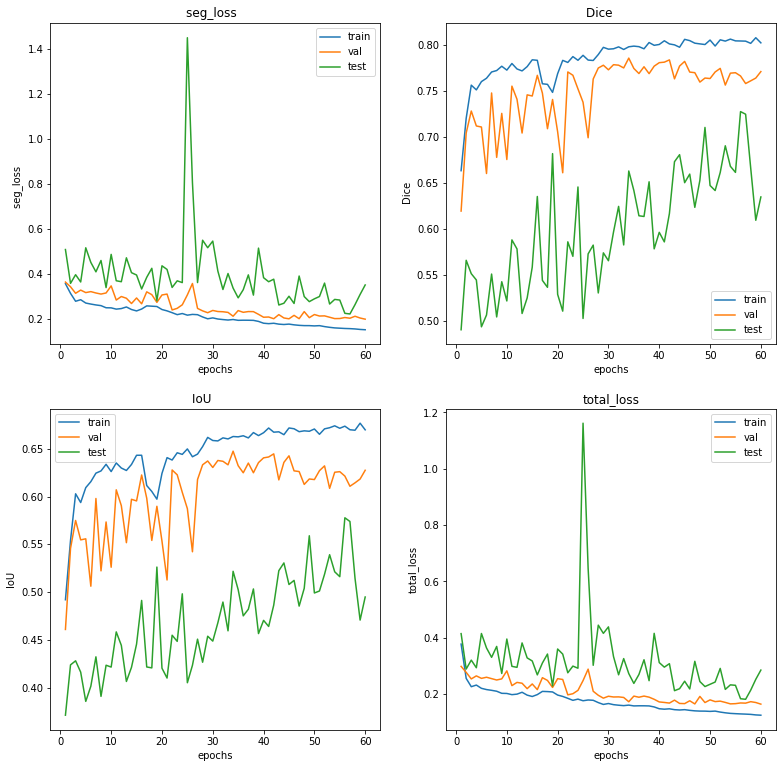

In [ ]:
#print(best_record_epoch)
best = torch.load(os.path.join(cp_PATH,str(data_import_options['k_fold'])+'.pt'))

re_final, record_test_final = model_eval(model_set, test_ds, \
                                         criterions, device, \
                                         'final', train_options['framework'])
re_best, record_test_best = model_eval(best, test_ds, \
                                       criterions, device, \
                                       'best', train_options['framework'])

log(loss_record_train, loss_record_val, loss_record_test, \
    [record_test_final, record_test_best], train_options['epochs'], cp_PATH)

plot(loss_record_train, loss_record_val, loss_record_test, \
     train_options['epochs'], cp_PATH)

In [ ]:
show(test_ds, re_final, cp_PATH, 'final', train_options['framework'])
print('---------------------------------------------------------------')
show(test_ds, re_best, cp_PATH, 'best', train_options['framework'])

Output hidden; open in https://colab.research.google.com to view.